# Simple LU

In [1]:
def partial_pivoting_lu(A):
    n = len(A)
    P = np.eye(n)  # начальная перестановочная матрица
    L = np.eye(n)  # начальная нижняя треугольная матрица
    U = np.copy(A)  # начальная верхняя треугольная матрица

    for j in range(n - 1):
        # Шаг 1: Находим максимальный элемент в столбце под главной диагональю
        pivot_row = np.argmax(np.abs(U[j:, j])) + j

        # Меняем строки в U, L и P соответственно
        U[[j, pivot_row], j:] = U[[pivot_row, j], j:]
        L[[j, pivot_row], :j] = L[[pivot_row, j], :j]
        P[[j, pivot_row], :] = P[[pivot_row, j], :]

        # Шаг 2: Обновляем матрицы L и U
        L[j + 1:, j] = U[j + 1:, j] / U[j, j]
        U[j + 1:, j:] -= np.outer(L[j + 1:, j], U[j, j:])

    return P, L, U

# Nested Dissection

## Без ускорения 

In [60]:
import numpy as np
import scipy.sparse as spsp
import matplotlib.pyplot as plt
import time

def custom_lu_decomposition_iter(L, U, i, j, n, m):
    # Итерация для LU-разложения
    for k in range(j, j + m):
        a = U.getrow(k).getcol(k).toarray()[0][0]
        for row in range(max(i, k + 1), i + n):
            b = U.getrow(row).getcol(k).toarray()[0][0]
            if b != 0:
                L.append((row, k, b / a))
                U[row] = U.getrow(row) - b * (U.getrow(k) / a)

def recursive_partitioning(P, L, U, i, n, separate_permutation):
    # Рекурсивное разбиение и применение LU-разложения
    if n < 10:  # Экстремальный случай
        custom_lu_decomposition_iter(L, U, i, i, n, n)
        return

    P_local, a, b, g = separate_permutation(U[i:(i+n), i:(i+n)])  # Получаем перестановку для блок-стрелочной формы
    P_i = np.arange(0, U.shape[0])  # Перестановка в i-й итерации
    P_i[i:(i+n)] = P_local + i
    U[:] = U[P_i, :][:, P_i]  # Применяем перестановку к U (в place)
    P[:] = P[P_i]

    if max(a, b, g) == n:  # Случай бесконечной рекурсии (когда следующее деление невозможно)
        custom_lu_decomposition_iter(L, U, i, i, n, n)
    else:
        recursive_partitioning(P, L, U, i, a, separate_permutation)  # (alpha, alpha)
        custom_lu_decomposition_iter(L, U, i + a + b, i, g, a)  # LU над частью (gamma,alpha)
        recursive_partitioning(P, L, U, i + a, b, separate_permutation)  # (beta, beta)
        custom_lu_decomposition_iter(L, U, i + a + b, i + a, g, b)  # LU над частью (gamma,beta)
        recursive_partitioning(P, L, U, i + a + b, g, separate_permutation)  # (gamma, gamma)

def lu_decomposition(A, separate_permutation, copy=True):
    # LU-разложение матрицы
    P = np.arange(0, A.shape[0])  # Перестановка по умолчанию
    L = [(i, i, 1) for i in range(0, A.shape[0])]  # Заполняем диагональ единицами

    if copy:
        U = A.copy()
    else:
        U = A

    # Изменения P, L, U вместе
    recursive_partitioning(P, L, U, 0, A.shape[0], separate_permutation)

    P = np.argsort(P)  # Применяем транспозицию

    # Создаем разреженную матрицу из списка COO
    row = [L[i][0] for i in range(len(L))]
    col = [L[i][1] for i in range(len(L))]
    data = [L[i][2] for i in range(len(L))]
    L = spsp.coo_matrix((data, (row, col)))

    return P, L, U

def generate_sparse_matrix(n, density=0.2):
    # Генерация разреженной матрицы размера n x n с указанной плотностью
    return spsp.rand(n, n, density=density, format='csr')

def find_separator_permutation(mat):
    # Находит собственный вектор Фидлера
    Laplacian = spsp.csgraph.laplacian(mat, dtype=np.float32)
    eigval, eigvec = spsp.linalg.eigsh(Laplacian, k=2, which="SM")
    colors = np.sign(eigvec[:, 1])

    # Получаем 3 множества, где gamma - разделитель
    if eigval[1] < 1e-8:  # Проверка на неподключенный граф
        alpha = spsp.csgraph.depth_first_order(Laplacian, 0, return_predecessors=False)
        beta = np.setdiff1d(np.arange(0, len(colors)), alpha)
        gamma = np.array([])
    else:
        gamma = set()
        for k in range(0, len(Laplacian.row)):
            i = Laplacian.row[k]
            j = Laplacian.col[k]
            if j > i and colors[i] != colors[j]:
                gamma.add(i)
                gamma.add(j)
        gamma = np.array(list(gamma))
        beta = np.setdiff1d(np.where(colors > 0), gamma)
        alpha = np.setdiff1d(np.where(colors < 0), gamma)

    # Создаем перестановку на основе множеств
    a, b, g = len(alpha), len(beta), len(gamma)
    start = 0
    P = np.zeros(len(colors), dtype=np.int32)
    if a > 0: P[alpha] = np.arange(start, start + a)
    start += a
    if b > 0: P[beta] = np.arange(start, start + b)
    start += b
    if g > 0: P[gamma] = np.arange(start, start + g)
    P = P.argsort()
    return P, a, b, g

<ipython-input-60-81e3590e962d>:13: RuntimeWarning: divide by zero encountered in double_scalars
  L.append((row, k, b / a))
/Users/akimkalenuk/opt/anaconda3/lib/python3.8/site-packages/scipy/sparse/_base.py:651: RuntimeWarning: divide by zero encountered in double_scalars
  return self.astype(np.float_)._mul_scalar(1./other)
/Users/akimkalenuk/opt/anaconda3/lib/python3.8/site-packages/scipy/sparse/_data.py:124: RuntimeWarning: invalid value encountered in multiply
  return self._with_data(self.data * other)


Время разложения [с] = 0.6882679462432861
Norm(A): 3.8547645237739117
Norm(LU): nan
Norm(P(LU)P - A): nan


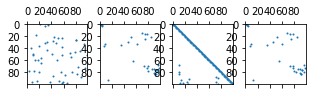

In [65]:
# Пример использования
if __name__ == '__main__':
    # Генерация разреженной матрицы
    n = 100
    density = 0.005
    A = generate_sparse_matrix(n, density)
    
    # Получение LU-разложения
    start_time = time.time()
    P, L, U = lu_decomposition(A, find_separator_permutation)
    end_time = time.time()
    print("Время разложения [с] =", end_time - start_time)
    
    # Проверка точности разложения
    LU = L.dot(U)
    norm_A = spsp.linalg.norm(A, ord='fro')
    norm_LU = spsp.linalg.norm(LU, ord='fro')
    norm_diff = spsp.linalg.norm(LU - A, ord='fro')

    print("Norm(A):", norm_A)
    print("Norm(LU):", norm_LU)
    print("Norm(P(LU)P - A):", norm_diff)

    # Визуализация разреженных матриц
    data = [A, LU, L, U]
    fig, axs = plt.subplots(1, len(data), figsize=(5, 5))
    for i in range(len(data)):
        axs[i].spy(data[i], aspect='equal', marker='.', markersize=2, precision=1e-5)
    plt.show()

## C ускорением

In [4]:
import numpy as np
import scipy.sparse as spsp
import matplotlib.pyplot as plt
import time
from numba import jit

@jit(nopython=True)
def custom_lu_decomposition_iter(L, U, i, j, n, m):
    for k in range(j, j + m):
        a = U[k, k]
        for row in range(max(i, k + 1), i + n):
            b = U[row, k]
            if b != 0:
                L.append((row, k, b / (a + 1e-16)))
                U[row, :] -= b * (U[k, :] / (a + 1e-16))

def generate_sparse_matrix(n, density=0.2):
    return spsp.rand(n, n, density=density, format='csr')

@jit(nopython=True)
def recursive_partitioning(P, L, U, i, n, separate_permutation):
    if n < 10:
        custom_lu_decomposition_iter(L, U, i, i, n, n)
        return

    P_local, a, b, g = separate_permutation(U[i:(i+n), i:(i+n)])
    P_i = np.arange(0, U.shape[0])
    P_i[i:(i+n)] = P_local + i
    U[:] = U[P_i, :][:, P_i]
    P[:] = P[P_i]

    if max(a, b, g) == n:
        custom_lu_decomposition_iter(L, U, i, i, n, n)
    else:
        recursive_partitioning(P, L, U, i, a, separate_permutation)
        custom_lu_decomposition_iter(L, U, i + a + b, i, g, a)
        recursive_partitioning(P, L, U, i + a, b, separate_permutation)
        custom_lu_decomposition_iter(L, U, i + a + b, i + a, g, b)
        recursive_partitioning(P, L, U, i + a + b, g, separate_permutation)

@jit(nopython=True)
def lu_decomposition(A, separate_permutation, copy=True):
    P = np.arange(0, A.shape[0])
    L = [(i, i, 1) for i in range(0, A.shape[0])]

    if copy:
        U = A.copy()
    else:
        U = A

    recursive_partitioning(P, L, U, 0, A.shape[0], separate_permutation)

    P = np.argsort(P)
    
    row = [L[i][0] for i in range(len(L))]
    col = [L[i][1] for i in range(len(L))]
    data = [L[i][2] for i in range(len(L))]
    L = spsp.coo_matrix((data, (row, col)))

    return P, L, U

@jit(nopython=True)
def find_separator_permutation(mat):
    Laplacian = spsp.csgraph.laplacian(mat, dtype=np.float32)
    eigval, eigvec = spsp.linalg.eigsh(Laplacian, k=2, which="SM")
    colors = np.sign(eigvec[:, 1])

    if eigval[1] < 1e-8:
        alpha = spsp.csgraph.depth_first_order(Laplacian, 0, return_predecessors=False)
        beta = np.setdiff1d(np.arange(0, len(colors)), alpha)
        gamma = np.array([])
    else:
        gamma = set()
        for k, (i, j) in enumerate(zip(Laplacian.row, Laplacian.col)):
            if j > i and colors[i] != colors[j]:
                gamma.add(i)
                gamma.add(j)
        gamma = np.array(list(gamma))
        beta = np.setdiff1d(np.where(colors > 0), gamma)
        alpha = np.setdiff1d(np.where(colors < 0), gamma)

    a, b, g = len(alpha), len(beta), len(gamma)
    start = 0
    P = np.zeros(len(colors), dtype=np.int32)
    if a > 0: P[alpha] = np.arange(start, start + a)
    start += a
    if b > 0: P[beta] = np.arange(start, start + b)
    start += b
    if g > 0: P[gamma] = np.arange(start, start + g)
    P = P.argsort()
    return P, a, b, g

if __name__ == '__main__':
    n = 1000
    density = 0.9
    A = generate_sparse_matrix(n, density)
    
    start_time = time.time()
    P, L, U = lu_decomposition(A, find_separator_permutation)
    end_time = time.time()
    print("Time for decomposition [s] =", end_time - start_time)
    
    LU = L.dot(U)
    norm_A = spsp.linalg.norm(A, ord='fro')
    norm_LU = spsp.linalg.norm(LU, ord='fro')
    norm_diff = spsp.linalg.norm(LU - A, ord='fro')

    print("Norm(A):", norm_A)
    print("Norm(LU):", norm_LU)
    print("Norm(P(LU)P - A):", norm_diff)

    data = [A, LU, L, U]
    fig, axs = plt.subplots(1, len(data))
    for i in range(len(data)):
        axs[i].spy(data[i], aspect='equal', marker='.', markersize=2, precision=1e-5)
    plt.show()

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1mnon-precise type pyobject[0m
[0m[1mDuring: typing of argument at <ipython-input-4-474e13f97749> (41)[0m
[1m
File "<ipython-input-4-474e13f97749>", line 41:[0m
[1mdef recursive_partitioning(P, L, U, i, n, separate_permutation):
    <source elided>

[1m@jit(nopython=True)
[0m[1m^[0m[0m 

This error may have been caused by the following argument(s):
- argument 0: [1mCannot determine Numba type of <class 'scipy.sparse._csr.csr_matrix'>[0m


In [143]:
%%time
P, L, U = lu_decomposition(A, find_separator_permutation)

CPU times: user 3.9 s, sys: 59.8 ms, total: 3.96 s
Wall time: 4.25 s


In [152]:
%%time
partial_pivoting_lu(A.todense())

CPU times: user 821 ms, sys: 106 ms, total: 926 ms
Wall time: 942 ms


(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[ 1.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  1.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.99277936, -0.85059862,  1.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.90970351,  0.04428585, -0.01793512, ...,  1.        ,
          0.        ,  0.        ],
        [ 0.73960683, -0.27439303,  0.41972144, ..., -0.12957754,
          1.        ,  0.        ],
        [ 0.62067006,  0.26239085,  0.3966598 , ..., -0.34958563,
         -0.02892685,  1.        ]]),
 array([[ 0.99962389,  0.95868826,  0.10765722, ...,  0.06838417,
          0.88745744,  0.65796604],
        [ 0.        , 

# Сравним библиотечные реализации

In [101]:
import numpy as np
from scipy.sparse import csr_matrix
import scipy.sparse as spsp
from scipy.sparse.linalg import splu, spilu
from scipy.linalg import lu
import timeit
from tqdm import tqdm
import matplotlib.pyplot as plt

def generate_sparse_matrix(n, density=0.2):
    return spsp.rand(n, n, density=density, format='csr')

def measure_time_and_accuracy(matrix_size, density):
    # Генерация разреженной матрицы
    A = generate_sparse_matrix(matrix_size, density)

    # LU-разложение с использованием различных методов
    lu_time = timeit.timeit(lambda: lu(A.todense()), number=1)
    splu_time = timeit.timeit(lambda: splu(A), number=1)
    spilu_time = timeit.timeit(lambda: spilu(A), number=1)

    # Расчет точности LU-разложения
    P, L, U = lu(A.todense())
    LU = L.dot(U)
    
    lu_norm_diff = np.linalg.norm(LU - A.todense(), ord='fro')
    
    B = splu(A)
    L = csr_matrix.todense(B.L)
    U = csr_matrix.todense(B.U)
    LU = L.dot(U)
    
    splu_norm_diff = np.linalg.norm(LU - A, ord='fro')
    
    B = spilu(A)
    L = csr_matrix.todense(B.L)
    U = csr_matrix.todense(B.U)
    LU = L.dot(U)
    
    spilu_norm_diff = np.linalg.norm(LU - A, ord='fro')
    
    return lu_time, splu_time, spilu_time, lu_norm_diff, splu_norm_diff, spilu_norm_diff

def plot_results(matrix_sizes, densities):
    lu_times = []
    splu_times = []
    spilu_times = []
    lu_accuracy_diffs = []
    splu_accuracy_diffs = []
    spilu_accuracy_diffs = []

    for size in tqdm(matrix_sizes):
        for density in tqdm(densities):
            lu_time, splu_time, spilu_time, lu_norm_diff, splu_norm_diff, spilu_norm_diff = measure_time_and_accuracy(size, 
                                                                                                                      density)

            lu_times.append(lu_time)
            splu_times.append(splu_time)
            spilu_times.append(spilu_time)
            
            lu_accuracy_diffs.append(lu_norm_diff)
            splu_accuracy_diffs.append(splu_norm_diff)
            spilu_accuracy_diffs.append(spilu_norm_diff)

    # Построение графиков
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.plot(lu_times, label='lu')
    plt.plot(splu_times, label='splu')
    plt.plot(spilu_times, label='spilu')
    plt.title('Execution Time Comparison')
    plt.xlabel('Configuration Index')
    plt.ylabel('Time (seconds)')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(lu_accuracy_diffs, label='lu')
    plt.plot(splu_accuracy_diffs, label='splu')
    plt.plot(spilu_accuracy_diffs, label='spilu')
    plt.title('LU Decomposition Accuracy')
    plt.xlabel('Configuration Index')
    plt.ylabel('Norm Difference')
    
    plt.tight_layout()
    plt.show()

# # Размеры и разреженности матриц
# matrix_sizes = range(10000, 100000, 10000)
# densities = [0.005, 0.01, 0.1]

# # Построение и отображение результатов
# plot_results(matrix_sizes, densities)

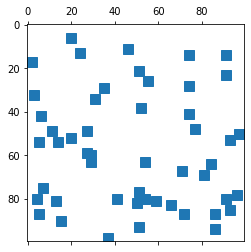

In [28]:
n = 100
A = spsp.random(n, n, 0.005)
plt.spy(A)
plt.show()

In [29]:
P, L, U = partial_pivoting_lu(A.todense())

<ipython-input-1-a2f61e89b6af>:17: RuntimeWarning: invalid value encountered in divide
  L[j + 1:, j] = U[j + 1:, j] / U[j, j]


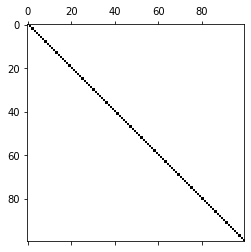

In [30]:
plt.spy(L)
plt.show()

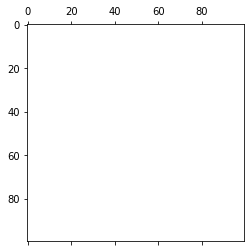

In [31]:
plt.spy(U)
plt.show()

In [89]:
A = spsp.csr_matrix(np.eye(50, 50)) + spsp.rand(50, 50, density=0.05, format='csr')

P, L, U = lu_decomposition(A.tocsc(), find_separator_permutation)

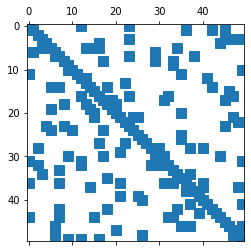

In [90]:
plt.spy(A)
plt.show()

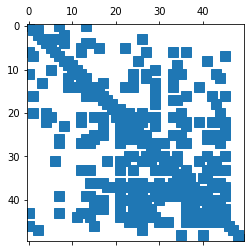

In [92]:
plt.spy(L@U)
plt.show()

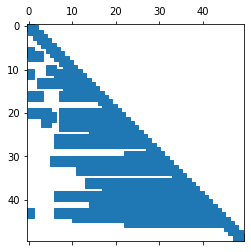

In [93]:
plt.spy(L)
plt.show()

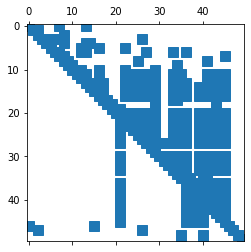

In [94]:
plt.spy(U)
plt.show()

In [104]:
P, L, U = lu(A.todense())

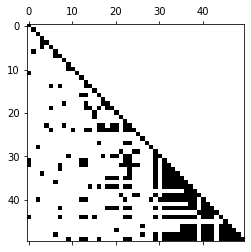

In [105]:
plt.spy(L)
plt.show()

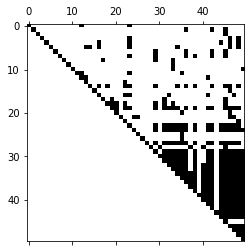

In [106]:
plt.spy(U)
plt.show()